# Expected Rating Model

## Objective

This notebook builds an Expected Rating model for Yelp businesses in Austin, TX.
The goal is to estimate what rating a business *should* receive based on observable
characteristics, then compute a Rating Delta to identify over- and under-performing businesses.


## Dataset Loading

The dataset contains business-level Yelp data for Austin, TX.

Business identifiers and names are preserved separately for interpretation and reporting
purposes but are excluded from model features to prevent leakage.


In [1]:
import pandas as pd 
import numpy as np
df = pd.read_csv('/Users/nathanho/Desktop/Yelp-BI/data/clean/austin_clean.csv')
df.head()

,business_id,name,city,state,address,postal_code,rating,review_count,price,price_level,is_closed,categories_alias,categories_title,latitude,longitude,search_location,search_category
0,cs6HfZNykLVitm09jWFqWg,Moonshine Grill,Austin,TX,"303 Red River St, Austin, TX 78701",78701,4.4,6314,$$,2.0,f,"southern, breakfast_brunch, cocktailbars","southern, breakfast & brunch, cocktail bars",30.263754,-97.738077,"Austin, TX",restaurants
1,He2KYtXXfaIR0nkCXH5xiQ,Loro Asian Smokehouse & Bar,Austin,TX,"2115 S Lamar Blvd, Austin, TX 78704",78704,4.3,2497,$$,2.0,f,"smokehouse, asianfusion, cocktailbars","smokehouse, asian fusion, cocktail bars",30.247740,-97.771355,"Austin, TX",restaurants
2,Rba9Ol4jnTiov6_iAuoF5g,1618 Asian Fusion,Austin,TX,"1618 E Riverside Dr, Austin, TX 78741",78741,4.7,3856,$$,2.0,f,"vietnamese, thai, dimsum","vietnamese, thai, dim sum",30.245474,-97.730411,"Austin, TX",restaurants
3,BHZ9puL8YuHE-YEdkmxH-g,Canje,Austin,TX,"1914 E 6th St, Ste C, Austin, TX 78702",78702,4.5,574,$$$,3.0,f,caribbean,caribbean,30.261770,-97.722320,"Austin, TX",restaurants
4,YZs1gNSh_sN8JmN_nrpxeA,Terry Black's Barbecue,Austin,TX,"1003 Barton Springs Rd, Austin, TX 78704",78704,4.5,8396,$$,2.0,f,"bbq, sandwiches, southern","barbeque, sandwiches, southern",30.259692,-97.754801,"Austin, TX",restaurants


## Exploratory Analysis (EDA)

This section contains exploratory analysis used to understand data quality,
feature behavior, missingness, and multicollinearity.
These steps informed final feature selection decisions.

## Dataset Overview

A brief overview of the dataset structure is provided below, including dimensions
and column names. Detailed exploratory analysis was conducted prior to modeling.

In [2]:
print(df.shape)
df.columns.tolist()
df.info()
df.describe(include='all')

(200, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   business_id       200 non-null    object 
 1   name              200 non-null    object 
 2   city              200 non-null    object 
 3   state             200 non-null    object 
 4   address           200 non-null    object 
 5   postal_code       200 non-null    int64  
 6   rating            200 non-null    float64
 7   review_count      200 non-null    int64  
 8   price             182 non-null    object 
 9   price_level       182 non-null    float64
 10  is_closed         200 non-null    object 
 11  categories_alias  200 non-null    object 
 12  categories_title  200 non-null    object 
 13  latitude          200 non-null    float64
 14  longitude         200 non-null    float64
 15  search_location   200 non-null    object 
 16  search_category   200 non-null    

,business_id,name,city,state,address,postal_code,rating,review_count,price,price_level,is_closed,categories_alias,categories_title,latitude,longitude,search_location,search_category
count,200,200,200,200,200,200.000000,200.000000,200.000000,182,182.000000,200,200,200,200.000000,200.000000,200,200
unique,200,187,1,1,199,NaN,NaN,NaN,4,NaN,1,168,168,NaN,NaN,1,1
top,cs6HfZNykLVitm09jWFqWg,Ramen Tatsu-Ya,Austin,TX,"500 W 5th St, Austin, TX 78701",NaN,NaN,NaN,$$,NaN,f,mexican,mexican,NaN,NaN,"Austin, TX",restaurants
freq,1,3,200,200,2,NaN,NaN,NaN,117,NaN,200,5,5,NaN,NaN,200,200
mean,NaN,NaN,NaN,NaN,NaN,78719.165000,4.274000,1048.805000,NaN,2.412088,NaN,NaN,NaN,30.289542,-97.740801,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,23.127086,0.236014,1124.890363,NaN,0.648387,NaN,NaN,NaN,0.040393,0.022076,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,78701.000000,3.800000,78.000000,NaN,1.000000,NaN,NaN,NaN,30.236097,-97.863070,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,78702.000000,4.100000,384.250000,NaN,2.000000,NaN,NaN,NaN,30.262192,-97.750108,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,78704.000000,4.300000,681.000000,NaN,2.000000,NaN,NaN,NaN,30.269570,-97.741581,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,78747.250000,4.400000,1292.000000,NaN,3.000000,NaN,NaN,NaN,30.312607,-97.727318,NaN,NaN


This provides a high-level overview of distributions, missingness,
and categorical cardinality across all features.

# Target Variable Analysis (Rating)

In [3]:
df["rating"].describe()
df["rating"].value_counts().sort_index()

rating
3.8     7
3.9    14
4.0    15
4.1    26
4.2    26
4.3    35
4.4    30
4.5    26
4.6    10
4.7     7
4.8     2
4.9     2
Name: count, dtype: int64

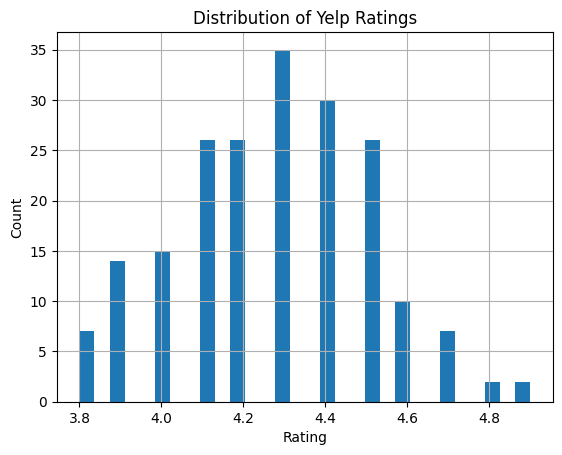

In [4]:
import matplotlib.pyplot as plt

df["rating"].hist(bins=30)
plt.title("Distribution of Yelp Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

Yelp ratings exhibit a positive skew, which is expected due to platform bias.
The target variable remains suitable for regression modeling.

# Missing Data Analysis

In [5]:
missing = df.isna().sum().sort_values(ascending=False)
missing

price               18
price_level         18
search_location      0
longitude            0
latitude             0
categories_title     0
categories_alias     0
is_closed            0
business_id          0
name                 0
review_count         0
rating               0
postal_code          0
address              0
state                0
city                 0
search_category      0
dtype: int64

In [6]:
# Percentage of missing values
(df.isna().sum() / len(df)).sort_values(ascending=False)

price               0.09
price_level         0.09
search_location     0.00
longitude           0.00
latitude            0.00
categories_title    0.00
categories_alias    0.00
is_closed           0.00
business_id         0.00
name                0.00
review_count        0.00
rating              0.00
postal_code         0.00
address             0.00
state               0.00
city                0.00
search_category     0.00
dtype: float64

In [7]:
# How many rows have any missing values?
df.isna().any(axis=1).sum()
# Confirm missingness is only in price-related columns
df.loc[df.isna().any(axis=1), ["price", "price_level"]].head()

,price,price_level
19,NaN,NaN
24,NaN,NaN
25,NaN,NaN
27,NaN,NaN
49,NaN,NaN


# Missing Data Conclusion

Only price-related features (`price` and `price_level`) contain missing values,
affecting 18 out of 200 businesses (~9%).
Missingness is fully localized and occurs jointly across both fields.
No missing values are present in the target or other predictors.
These features will be retained and handled via imputation
within the preprocessing pipeline.

# Multicollinearity Analysis
Multicollinearity among numeric predictors was evaluated using correlation analysis
and Variance Inflation Factor (VIF).

In [8]:
NumericCols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
NumericCols

['postal_code',
 'rating',
 'review_count',
 'price_level',
 'latitude',
 'longitude']

In [9]:
NumericCols.remove('rating')
NumericCols

['postal_code', 'review_count', 'price_level', 'latitude', 'longitude']

In [10]:
df[NumericCols].corr()

,postal_code,review_count,price_level,latitude,longitude
postal_code,1.000000,-0.055750,-0.167878,0.850890,0.192226
review_count,-0.055750,1.000000,-0.120966,-0.134231,0.017297
price_level,-0.167878,-0.120966,1.000000,-0.134601,-0.022731
latitude,0.850890,-0.134231,-0.134601,1.000000,0.198993
longitude,0.192226,0.017297,-0.022731,0.198993,1.000000


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Drop rows with missing numeric values for VIF calculation
VIFdf = df[NumericCols].dropna()

# Add intercept
XVIF = np.column_stack([np.ones(len(VIFdf)), VIFdf.values])

VIFData = pd.DataFrame({
    "feature": ["intercept"] + NumericCols,
    "VIF": [variance_inflation_factor(XVIF, i) for i in range(XVIF.shape[1])]
})

VIFData


,feature,VIF
0,intercept,5.153432e+07
1,postal_code,3.786247e+00
2,review_count,1.059178e+00
3,price_level,1.048617e+00
4,latitude,3.863420e+00
5,longitude,1.046927e+00


### Multicollinearity Conclusion

Variance Inflation Factor (VIF) analysis indicates low multicollinearity among
numeric predictors. Geographic features exhibit moderate correlation, which is
expected. Although postal_code does not exceed standard VIF thresholds, it is
excluded from modeling because ZIP codes are identifiers rather than meaningful
numeric quantities. Latitude and longitude are retained to capture location effects. Multicollinearity is noted but not prohibitive for baseline linear modeling.

# Preprocessing Pipeline

Preprocessing is implemented using a ColumnTransformer with separate pipelines:

**Numeric Pipeline**
- Median imputation to handle missing values
- Standard scaling to normalize feature values

**Categorical Pipeline**
- Most-frequent imputation for missing values
- One-hot encoding with unknown category handling to capture categorical level effects.

This approach ensures consistent preprocessing across training and evaluation.

In [12]:
df.columns.tolist()

['business_id',
 'name',
 'city',
 'state',
 'address',
 'postal_code',
 'rating',
 'review_count',
 'price',
 'price_level',
 'is_closed',
 'categories_alias',
 'categories_title',
 'latitude',
 'longitude',
 'search_location',
 'search_category']

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Final Feature Selection

Based on exploratory analysis and domain reasoning, the following features
are retained for modeling. This marks the transition from exploration to modeling.

In [14]:
NonFeatureCols = [
    "business_id",
    "name",
    "address",
    "postal_code",
    "state",
    "categories_alias",
    "categories_title",
    "search_location",
    "is_closed",
    "rating",
    "price", # due to redundancy with price_level
    "city"
]

X = df.drop(columns=NonFeatureCols)
Y = df["rating"]

In [15]:
NumericFeatures = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
CategoricalFeatures = X.select_dtypes(include=["object", "bool"]).columns.tolist()

NumericFeatures, CategoricalFeatures

(['review_count', 'price_level', 'latitude', 'longitude'], ['search_category'])

# Combined Preprocessing Strategy

Numeric and categorical preprocessing pipelines are combined using a
`ColumnTransformer`. This enables parallel processing of feature types and
ensures all transformations are applied consistently across datasets.

In [16]:
NumericTransformer = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="median")),
    ("Scaler", StandardScaler())
])

CategoricalTransformer = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="most_frequent")),
    ("Encoder", OneHotEncoder(handle_unknown="ignore"))
])

Preprocessor = ColumnTransformer(
    transformers=[
        ("Numeric", NumericTransformer, NumericFeatures),
        ("Categorical", CategoricalTransformer, CategoricalFeatures)
    ]
)

# Train–Test Split

The dataset is split into training and testing sets using an 80/20 split.
A fixed random state is used to ensure reproducibility of results.

In [17]:
from sklearn.model_selection import train_test_split

XTrain, XTest, YTrain, YTest = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=42
)

# Expected Rating Model (Baseline)

A Linear Regression model is used as the baseline estimator for predicting
expected Yelp ratings.

This model was chosen for:
- Interpretability
- Stable residual behavior
- Establishing a benchmark for more complex models


In [18]:
from sklearn.linear_model import LinearRegression
ExpectedRatingModel = Pipeline(steps=[
    ("Preprocessor", Preprocessor),
    ("Regressor", LinearRegression())
])

ExpectedRatingModel.fit(XTrain, YTrain)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('Numeric',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['review_count',
                                                   'price_level', 'latitude',
                                                   'longitude']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['search_category'])])),
                ('Regressor', LinearRegression())])

# Model Training

The preprocessing pipeline and regression model are combined into a single
end-to-end pipeline and trained on the training dataset.


# Model Evaluation

Model performance is evaluated using:

- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

These metrics quantify average prediction error in star ratings.

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
YPred = ExpectedRatingModel.predict(XTest)

MAE = mean_absolute_error(YTest, YPred)
RMSE = np.sqrt(mean_squared_error(YTest, YPred))

MAE, RMSE

(0.2011713796112568, 0.23564654947280936)

# Interpreting MAE and RMSE

The Expected Rating model achieves a **Mean Absolute Error (MAE) of approximately 0.20**
and a **Root Mean Squared Error (RMSE) of approximately 0.24**.

MAE represents the average absolute difference between predicted and actual Yelp ratings,
indicating that the model’s predictions are typically within **about 0.2 stars** of the
true rating. RMSE penalizes larger errors more heavily and provides additional insight
into the presence of outlier predictions.

Given the inherent noise and subjectivity in Yelp ratings, as well as the limited feature
set and dataset size, this level of error indicates **strong baseline performance**.
These results suggest that observable attributes such as price level, review volume,
category, and location capture meaningful signal in explaining business ratings.

# Business Insight: Rating Delta

The primary business-facing output of the model is **Rating Delta**, defined as:

**Rating Delta = Actual Rating − Predicted Rating**

This metric identifies:
- Overperforming businesses (positive delta)
- Underperforming businesses (negative delta)

These results are designed to feed downstream BI dashboards.

In [20]:
Results = XTest.copy()
Results["ActualRating"] = YTest
Results["PredictedRating"] = YPred
Results["RatingDelta"] = Results["ActualRating"] - Results["PredictedRating"]

Results.sort_values("RatingDelta", ascending=False).head(10)

,review_count,price_level,latitude,longitude,search_category,ActualRating,PredictedRating,RatingDelta
56,445,2.0,30.266290,-97.745975,restaurants,4.7,4.255938,0.444062
55,1802,2.0,30.284804,-97.713964,restaurants,4.7,4.329399,0.370601
66,285,3.0,30.299900,-97.740310,restaurants,4.6,4.276976,0.323024
164,111,NaN,30.319075,-97.739501,restaurants,4.6,4.297136,0.302864
45,629,2.0,30.284983,-97.716848,restaurants,4.6,4.319636,0.280364
125,167,4.0,30.247400,-97.750060,restaurants,4.5,4.220120,0.279880
95,2032,2.0,30.241613,-97.758876,restaurants,4.5,4.224812,0.275188
18,271,4.0,30.269544,-97.749509,restaurants,4.5,4.234522,0.265478
30,1373,2.0,30.268470,-97.727610,restaurants,4.5,4.293728,0.206272
16,3145,4.0,30.257539,-97.759796,restaurants,4.4,4.220678,0.179322


# Adding back the Business Identifiers
After generating predictions and computing Rating Deltas,
the business identifiers and names are merged back into the results
for interpretation and reporting purposes.

In [21]:
Meta = df[["business_id", "name"]].copy()

Results["business_id"] = Meta.loc[Results.index, "business_id"]
Results["name"] = Meta.loc[Results.index, "name"]

# Overperforming Businesses
The table above highlights businesses with the largest positive **Rating Delta**,
meaning their actual Yelp ratings exceed what the model would expect given their
observable characteristics. 

In [22]:
Results.sort_values("RatingDelta", ascending=False).head(10)

,review_count,price_level,latitude,longitude,search_category,ActualRating,PredictedRating,RatingDelta,business_id,name
56,445,2.0,30.266290,-97.745975,restaurants,4.7,4.255938,0.444062,GZfHsTQAabxdXB_z30h6kw,DeSano Pizzeria Napoletana
55,1802,2.0,30.284804,-97.713964,restaurants,4.7,4.329399,0.370601,PrWSjn4a8o4dHoqKs53GBA,Bird Bird Biscuit
66,285,3.0,30.299900,-97.740310,restaurants,4.6,4.276976,0.323024,Bz-NZ-2Dx6pztO0nvfD3JA,Nori
164,111,NaN,30.319075,-97.739501,restaurants,4.6,4.297136,0.302864,r7m-V0drTnK9o2Mg1FcxAQ,Gràcia Mediterranean
45,629,2.0,30.284983,-97.716848,restaurants,4.6,4.319636,0.280364,Unl62KlI0kwF8pToy7QjSA,Vic & Al's
125,167,4.0,30.247400,-97.750060,restaurants,4.5,4.220120,0.279880,CLcRsv9px0tbBkPkRN5qBQ,Otoko
95,2032,2.0,30.241613,-97.758876,restaurants,4.5,4.224812,0.275188,KEh3efWSOIzd8BvuW-X4-g,Phoebe's Diner
18,271,4.0,30.269544,-97.749509,restaurants,4.5,4.234522,0.265478,wKQNqpvphl0zGCv9JuIN8Q,J Carver’s
30,1373,2.0,30.268470,-97.727610,restaurants,4.5,4.293728,0.206272,jmmzYxurOoA_K_RtanzQow,Paperboy East
16,3145,4.0,30.257539,-97.759796,restaurants,4.4,4.220678,0.179322,zFaHweOJ40jjtvpGTjlspw,Uchi Austin


# Underperforming Businesses
The table above highlights businesses with the largest negative **Rating Delta**,
meaning their actual Yelp ratings fall short of what the model would expect given their
observable characteristics.

In [23]:
Results.sort_values("RatingDelta", ascending=True).head(10)

,review_count,price_level,latitude,longitude,search_category,ActualRating,PredictedRating,RatingDelta,business_id,name
124,944,2.0,30.317058,-97.719566,restaurants,3.8,4.334884,-0.534884,u5XqU3ys3nXd1Ee0XYKLWg,Foreign & Domestic
152,620,2.0,30.298554,-97.740989,restaurants,3.9,4.284481,-0.384481,6e3UQmbqFLGWWDCI5VczCA,Hopfields
93,683,2.0,30.298400,-97.704748,restaurants,4.0,4.349327,-0.349327,xyvGNML9BW-3seLMqeYCWA,Colleen's Kitchen
75,2039,2.0,30.357639,-97.733130,restaurants,4.0,4.338903,-0.338903,67bZm-KQQCwSat7_jmiVbA,Hopdoddy Burger Bar
82,1049,3.0,30.253860,-97.712900,restaurants,4.0,4.301943,-0.301943,yqL1P6wcSZYQAgpO3TfhBQ,Kemuri Tatsu-ya
67,2193,2.0,30.264941,-97.743749,restaurants,4.0,4.266152,-0.266152,9e5lIroM6Eyd4aS26pWWEQ,Cooper's Old Time Pit Bar-B-Que
69,987,3.0,30.256941,-97.739332,restaurants,4.0,4.256326,-0.256326,U72ZAUh47P1cX-91jqLpJw,Emmer & Rye
78,1232,3.0,30.265660,-97.743238,restaurants,4.0,4.255460,-0.255460,CqOkl94q9ttvYNWIITA8ow,Swift's Attic
84,1118,3.0,30.356725,-97.731240,restaurants,4.1,4.329876,-0.229876,SRwJ6tNJ6r7hQ3uQ7hIBpQ,Bartlett's
177,848,2.0,30.263260,-97.726240,restaurants,4.1,4.291003,-0.191003,7ZU9DwctpN_tkC7EOd3C-Q,Ramen Tatsu-Ya


# Interpreting the Results

The tables above present businesses with the largest positive and negative **Rating Delta**
values. Rating Delta measures the difference between a business’s actual Yelp rating and
the rating predicted by the model given its price level, review volume, category, and
location.

Businesses with positive Rating Delta values can be interpreted as **overperformers** or
**“hidden gems,”** achieving higher customer satisfaction than peers with similar observable
characteristics. Conversely, businesses with negative Rating Delta values may be considered
**underperformers**, receiving lower ratings than the model would expect.

Rather than assigning causality, this analysis provides a relative performance signal that
can guide further qualitative investigation, operational review, or strategic replication.
This demonstrates how the Expected Rating model extends beyond prediction to deliver
actionable business insight.


# Model Comparison: Regularized Regression

To evaluate the robustness of the baseline model, Ridge and Lasso regression
were trained and compared using the same preprocessing pipeline and evaluation
metrics.

# Ridge Regression
Ridge regression introduces L2 regularization to the linear model,
which can help mitigate overfitting and improve generalization. The model
was trained and evaluated using the established pipeline.

In [24]:
from sklearn.linear_model import Ridge

RidgeModel = Pipeline(steps=[
    ("Preprocessor", Preprocessor),
    ("Regressor", Ridge(alpha=1.0))
])

RidgeModel.fit(XTrain, YTrain)

RidgePred = RidgeModel.predict(XTest)

RidgeMAE = mean_absolute_error(YTest, RidgePred)
RidgeRMSE = np.sqrt(mean_squared_error(YTest, RidgePred))

RidgeMAE, RidgeRMSE

(0.20116452768079024, 0.23559424193973655)

# Lasso Regression
Lasso regression applies L1 regularization, which can perform feature selection
by shrinking some coefficients to zero. This model was also trained and evaluated
using the established pipeline.

In [25]:
from sklearn.linear_model import Lasso

LassoModel = Pipeline(steps=[
    ("Preprocessor", Preprocessor),
    ("Regressor", Lasso(alpha=0.01))
])

LassoModel.fit(XTrain, YTrain)

LassoPred = LassoModel.predict(XTest)

LassoMAE = mean_absolute_error(YTest, LassoPred)
LassoRMSE = np.sqrt(mean_squared_error(YTest, LassoPred))

LassoMAE, LassoRMSE

(0.20028519782140894, 0.23283769334392354)

In [26]:
ModelComparison = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Lasso Regression"],
    "MAE": [MAE, RidgeMAE, LassoMAE],
    "RMSE": [RMSE, RidgeRMSE, LassoRMSE]
})

ModelComparison

,Model,MAE,RMSE
0,Linear Regression,0.201171,0.235647
1,Ridge Regression,0.201165,0.235594
2,Lasso Regression,0.200285,0.232838


# Model Comparison Interpretation

All three regression models exhibit very similar predictive performance, indicating
that the relationship between the selected features and Yelp ratings is largely linear.
Regularization does not dramatically change model accuracy, suggesting that the baseline
feature set is stable and well-conditioned.

Lasso regression achieves the lowest MAE and RMSE among the tested models, providing a
slight improvement in predictive accuracy while also encouraging sparsity in the
one-hot encoded categorical features. Given this marginal performance gain and the
added benefit of regularization, Lasso regression is selected as the final model for
downstream analysis.

# Final Model Selection
Lasso regression is retained as the final Expected Rating model due to its slightly
improved performance and regularization benefits.

In [27]:
FinalModel = LassoModel

FinalPred = FinalModel.predict(XTest)

FinalResults = XTest.copy()
FinalResults["ActualRating"] = YTest
FinalResults["PredictedRating"] = FinalPred
FinalResults["RatingDelta"] = FinalResults["ActualRating"] - FinalResults["PredictedRating"]

FinalResults["business_id"] = Meta.loc[FinalResults.index, "business_id"]
FinalResults["name"] = Meta.loc[FinalResults.index, "name"]

In [29]:
FinalResults.sort_values("RatingDelta", ascending=False).head(10)

,review_count,price_level,latitude,longitude,search_category,ActualRating,PredictedRating,RatingDelta,business_id,name
56,445,2.0,30.266290,-97.745975,restaurants,4.7,4.262818,0.437182,GZfHsTQAabxdXB_z30h6kw,DeSano Pizzeria Napoletana
55,1802,2.0,30.284804,-97.713964,restaurants,4.7,4.315114,0.384886,PrWSjn4a8o4dHoqKs53GBA,Bird Bird Biscuit
66,285,3.0,30.299900,-97.740310,restaurants,4.6,4.283447,0.316553,Bz-NZ-2Dx6pztO0nvfD3JA,Nori
164,111,NaN,30.319075,-97.739501,restaurants,4.6,4.291782,0.308218,r7m-V0drTnK9o2Mg1FcxAQ,Gràcia Mediterranean
45,629,2.0,30.284983,-97.716848,restaurants,4.6,4.311095,0.288905,Unl62KlI0kwF8pToy7QjSA,Vic & Al's
95,2032,2.0,30.241613,-97.758876,restaurants,4.5,4.235288,0.264712,KEh3efWSOIzd8BvuW-X4-g,Phoebe's Diner
125,167,4.0,30.247400,-97.750060,restaurants,4.5,4.249948,0.250052,CLcRsv9px0tbBkPkRN5qBQ,Otoko
18,271,4.0,30.269544,-97.749509,restaurants,4.5,4.259031,0.240969,wKQNqpvphl0zGCv9JuIN8Q,J Carver’s
30,1373,2.0,30.268470,-97.727610,restaurants,4.5,4.289656,0.210344,jmmzYxurOoA_K_RtanzQow,Paperboy East
16,3145,4.0,30.257539,-97.759796,restaurants,4.4,4.239955,0.160045,zFaHweOJ40jjtvpGTjlspw,Uchi Austin


In [30]:
FinalResults.sort_values("RatingDelta", ascending=True).head(10)

,review_count,price_level,latitude,longitude,search_category,ActualRating,PredictedRating,RatingDelta,business_id,name
124,944,2.0,30.317058,-97.719566,restaurants,3.8,4.319271,-0.519271,u5XqU3ys3nXd1Ee0XYKLWg,Foreign & Domestic
152,620,2.0,30.298554,-97.740989,restaurants,3.9,4.281979,-0.381979,6e3UQmbqFLGWWDCI5VczCA,Hopfields
93,683,2.0,30.298400,-97.704748,restaurants,4.0,4.333270,-0.333270,xyvGNML9BW-3seLMqeYCWA,Colleen's Kitchen
75,2039,2.0,30.357639,-97.733130,restaurants,4.0,4.315268,-0.315268,67bZm-KQQCwSat7_jmiVbA,Hopdoddy Burger Bar
82,1049,3.0,30.253860,-97.712900,restaurants,4.0,4.305019,-0.305019,yqL1P6wcSZYQAgpO3TfhBQ,Kemuri Tatsu-ya
69,987,3.0,30.256941,-97.739332,restaurants,4.0,4.268724,-0.268724,U72ZAUh47P1cX-91jqLpJw,Emmer & Rye
78,1232,3.0,30.265660,-97.743238,restaurants,4.0,4.266460,-0.266460,CqOkl94q9ttvYNWIITA8ow,Swift's Attic
67,2193,2.0,30.264941,-97.743749,restaurants,4.0,4.265467,-0.265467,9e5lIroM6Eyd4aS26pWWEQ,Cooper's Old Time Pit Bar-B-Que
84,1118,3.0,30.356725,-97.731240,restaurants,4.1,4.317604,-0.217604,SRwJ6tNJ6r7hQ3uQ7hIBpQ,Bartlett's
177,848,2.0,30.263260,-97.726240,restaurants,4.1,4.289643,-0.189643,7ZU9DwctpN_tkC7EOd3C-Q,Ramen Tatsu-Ya


# Saving Final Results
The final results, including business identifiers, actual ratings, predicted ratings,
and Rating Delta values, are saved to a CSV file for integration into downstream
BI dashboards and reporting.

In [32]:
FinalResults.to_csv(
    "/Users/nathanho/Desktop/Yelp-BI/data/kpi/expected_rating_results.csv",
    index=False
)

# Linear vs Lasso Model Comparison

To validate the robustness of the Expected Rating signal, results from the baseline Linear Regression model were compared against the final Lasso Regression model. While both models use the same feature set and preprocessing pipeline, Lasso introduces regularization that refines how feature contributions are weighted.

# Consistency of Results

Across both models, largely the same businesses appear among the highest and lowest Rating Delta values. This consistency indicates that the identification of overperforming and underperforming businesses is not driven by a specific modeling choice, but instead reflects a stable underlying signal in the data.
The agreement in direction and ranking between models strengthens confidence that the results are meaningful and not artifacts of overfitting or noise.

# Differences in Magnitude

While rankings remain similar, the magnitude of Rating Delta values differs between the two approaches:

- Linear Regression tends to produce more extreme positive and negative deviations.

- Lasso Regression produces more conservative deviations by shrinking the influence of weaker or correlated features.

As a result, Lasso dampens extreme predictions while preserving relative ordering. This leads to a more stable and interpretable performance signal, particularly when features exhibit correlation or limited sample size.

# Interpretation

The Linear Regression model serves as an effective baseline for understanding the expected relationship between business characteristics and Yelp ratings. The Lasso model refines this baseline by improving robustness without materially changing the business conclusions.
In practice, this means that:

- Linear Regression confirms the presence of meaningful signal

- Lasso Regression provides a cleaner, more reliable version of that signal for downstream analysis

# Final Model Choice

Given the strong alignment between models and the added regularization benefits, Lasso Regression was selected as the final model. Its outputs are better suited for business-facing interpretation and integration into BI dashboards, where stability and interpretability are prioritized over maximizing coefficient magnitude.

## Final Thoughts

This project developed an end-to-end Expected Rating model to evaluate Yelp businesses relative to their observable characteristics. Starting from raw Yelp Fusion API data, the workflow progressed through data cleaning, exploratory analysis, feature selection, and model development to produce a practical, business-facing performance signal.

A baseline Linear Regression model was first used to establish that meaningful relationships exist between business attributes such as price level, review volume, category, and location and observed Yelp ratings. Building on this foundation, a Lasso Regression model was selected as the final model to improve robustness through regularization while maintaining interpretability.

The final model achieves strong predictive performance, with an average error of approximately 0.2 Yelp stars, indicating that predictions are closely aligned with true ratings despite the inherent noise and subjectivity of customer reviews. Comparing predicted and actual ratings enables the identification of businesses that overperform or underperform relative to expectations in a consistent, data-driven manner.

Rather than assigning causality, the model provides a normalized benchmark for performance that accounts for key contextual factors. This allows raw ratings to be interpreted more meaningfully and supports deeper investigation into operational excellence, pricing strategy, and customer experience.

Overall, this project demonstrates how machine learning can extend traditional business intelligence workflows by introducing contextual performance benchmarking. The resulting outputs are designed for integration into downstream BI dashboards and strategic analysis, offering actionable insight grounded in both statistical rigor and business relevance.